<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/classifica%C3%A7%C3%A3o/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing

names = [
         "NUM_CURSOS",
         "CODIGO_IES",
         "DEFICIENCIA_FISICA",
         "DEFICIENCIA_VISUAL",
         "DEFICIENCIA_AUDITIVA", 
         "DEFICIENCIA_COGNITIVA", 
         "DEFICIENCIA_MULTIPLA", 
         "RECURSOS_DEF_FISICA",
         "RECURSOS_DEF_VISUAL", 
         "RECURSOS_DEF_AUDITIVA", 
         "RECURSOS_DEF_COGNITIVA",
         "RECURSOS_DEF_MULTIPLA"
         ]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(names)
names=le.transform(names)
print(names) 

dataset = pd.read_csv("dados_ies.csv", index_col=0, encoding="latin-1")

#Substitui NaN por 0
#dataset.fillna("NaN", inplace=True)

dataset.dropna(subset=["TIPO_CATEGORIA_ADM"], inplace=True)

set(dataset["TIPO_CATEGORIA_ADM"])

[ 6  0  3  5  1  2  4  9 11  7  8 10]


{'Especial',
 'Privada com fins lucrativos',
 'Privada sem fins lucrativos',
 'Pública Estadual',
 'Pública Federal',
 'Pública Municipal'}

Processa células não padronizadas (células vazias)

In [111]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in dataset.columns:
  if dataset[i].dtype == object:
    dataset[i] = le.fit_transform(dataset[i])
  else:
    pass

dataset_encoded = le.fit_transform(dataset.columns)

Normaliza os dados usando StandardScaler e treina o modelo

In [116]:
X = dataset.drop(columns=["REGIAO", "TIPO_CATEGORIA_ADM", "UF", "CODIGO_IES"])
y = dataset["TIPO_CATEGORIA_ADM"].values

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y=le.transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Cria o objeto KNN

In [117]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [86]:
y_pred

array([3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 2, 0, 1, 3, 4, 3, 3, 3, 3, 3, 1,
       3, 4, 1, 0, 1, 0, 3, 1, 1, 0, 4, 3, 3, 3, 3, 3, 3, 1, 0, 4, 1, 3,
       3, 3, 1, 3, 1, 3, 4, 4, 1, 3, 1, 2, 1, 0, 0, 3, 3, 1, 1, 3, 2, 1,
       2, 3, 3, 3, 3, 1, 0, 1, 3, 0, 3, 0, 3, 4, 3, 0, 1, 3, 3, 3, 1, 3,
       4, 3, 1, 4, 3, 3, 3, 0, 3, 1, 3, 3, 3, 4, 1, 3, 0, 1, 2, 1, 1, 3,
       3, 1, 0, 3, 4, 1, 3, 3, 0, 1, 1, 3, 3, 1, 3, 3, 4, 1, 1, 3, 3, 3,
       0, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3,
       1, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 0, 1, 3, 3, 1,
       3, 3, 0, 4, 3, 0, 3, 3, 1, 1, 3, 3, 3, 4, 0, 3, 3, 3, 1, 3, 1, 3,
       4, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 4, 1, 4, 3, 1, 0, 3, 3, 3,
       1, 0, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 4,
       1, 3, 3, 3, 3, 3, 0, 3, 3, 4, 2, 3, 0, 3, 4, 3, 4, 1, 3, 3, 3, 2,
       0, 4, 3, 0, 1, 3, 3, 0, 3, 3, 1, 3])

Faz a predição

In [118]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  0   0   1   0   0   0]
 [  0 104  37   0   2   0]
 [  0  55  35   0   1   0]
 [  0   9   7   0   1   0]
 [  0   5   3   1   6   0]
 [  0   6   3   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.58      0.73      0.65       143
           2       0.41      0.38      0.40        91
           3       0.00      0.00      0.00        17
           4       0.60      0.40      0.48        15
           5       0.00      0.00      0.00         9

    accuracy                           0.53       276
   macro avg       0.26      0.25      0.25       276
weighted avg       0.47      0.53      0.49       276



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Mean Error')

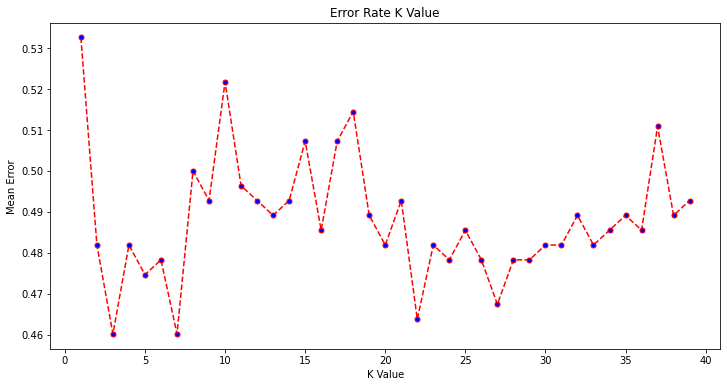

In [120]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [122]:
pip install adspy_shared_utilities

ERROR: Could not find a version that satisfies the requirement adspy_shared_utilities (from versions: none)
ERROR: No matching distribution found for adspy_shared_utilities


In [121]:
from adspy_shared_utilities import plot_two_class_knn
plot_two_class_knn(X_train, y_train, 1, "uniform", X_test, y_test)

ModuleNotFoundError: ignored